LinearRegression only works for binomial expressions.
But if we use get_dummies 

In [ ]:
import pandas as pd

transport_df = pd.read_csv(r'C:\Users\Gareth.Ahern\Desktop\LinRegTesting.csv')
transport_df.head()

This is a made up data set
Car
Speed between 1 and 4
Altitude between 0 and 3
Environment between 3 and 7

Plane
Speed between 6 and 10
Altitude between 6 and 10
Environment between 0 and 3


Train
Speed between 4 and 7
Altitude between 0 and 3
Environment between 7 and 10

In [106]:
transport_df.transport.value_counts().sort_index()

Car      20
Plane    21
Train    20
Name: transport, dtype: int64

We have 20 records of each type, and one extra for Plane...

In [88]:
transport_df.describe()

,max_speed,max_altitude,environment
count,61.000000,61.000000,61.000000
mean,5.229508,3.508197,4.934426
std,2.824851,3.253833,2.971357
min,1.000000,0.000000,0.000000
25%,3.000000,1.000000,3.000000
50%,6.000000,2.000000,5.000000
75%,7.000000,7.000000,7.000000
max,10.000000,10.000000,10.000000


In this plot you can see thta Plane has one outlier:

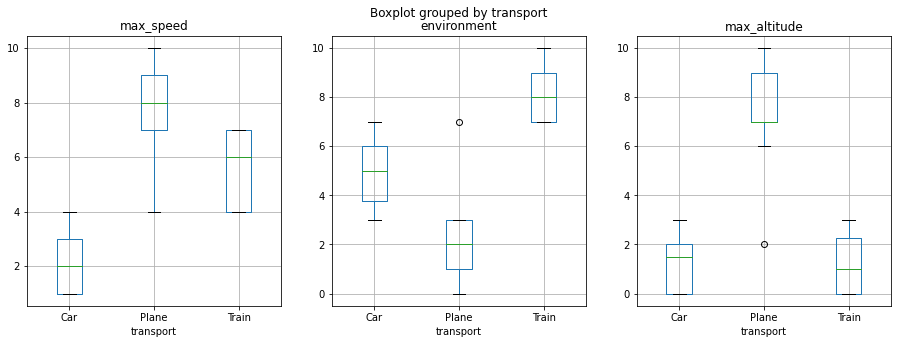

In [118]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

transport_df.boxplot(column='max_speed', by='transport', ax=axs[0]);
transport_df.boxplot(column='environment', by='transport', ax=axs[1]);
transport_df.boxplot(column='max_altitude', by='transport', ax=axs[2]);

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

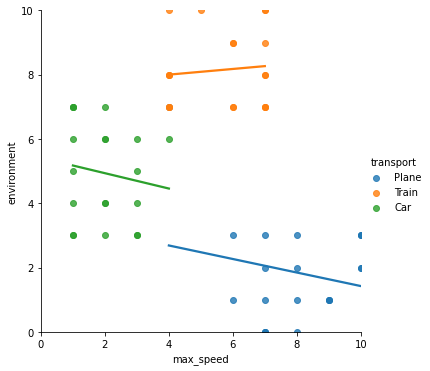

In [122]:
sns.lmplot(x='max_speed', y='environment', data=transport_df, ci=None, hue='transport');
plt.xlim(0, 10);
plt.ylim(0, 10);

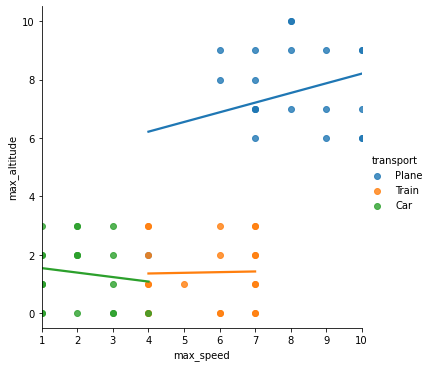

In [131]:
sns.lmplot(x='max_speed', y='max_altitude', data=transport_df, ci=None, hue='transport');

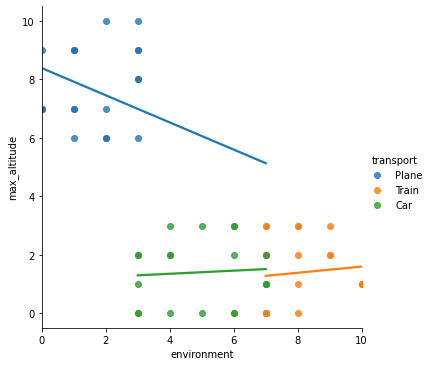

In [91]:
sns.lmplot(x='environment', y='max_altitude', data=transport_df, ci=None, hue='transport');

Lets create 3 dummy columns that have boolean expression showing if transport is a Car/Train/Plane

In [92]:
dummy_df = transport_df
dummy_df['tran'] = dummy_df['transport']
dummy_df =pd.get_dummies(transport_df,columns=['tran'])
dummy_df.head()

,max_speed,max_altitude,environment,transport,tran_Car,tran_Plane,tran_Train
0,6,8,3,Plane,0,1,0
1,10,9,3,Plane,0,1,0
2,7,6,2,Plane,0,1,0
3,7,7,0,Plane,0,1,0
4,7,7,1,Plane,0,1,0


Using LogistricRegression we can calculate the odds that the three features are of a car

In [93]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

feature_cols = ['environment','max_altitude','max_speed']
X = dummy_df[feature_cols]
y = dummy_df.tran_Car

logreg.fit(X,y)
pred = logreg.predict(X)
logreg.predict_proba(X)[0:10]

array([[9.91049134e-01, 8.95086639e-03],
       [9.99995793e-01, 4.20692122e-06],
       [9.90586695e-01, 9.41330468e-03],
       [9.66889766e-01, 3.31102335e-02],
       [9.86027989e-01, 1.39720107e-02],
       [9.32606538e-01, 6.73934624e-02],
       [9.99509493e-01, 4.90506985e-04],
       [9.57314688e-01, 4.26853121e-02],
       [9.99796973e-01, 2.03027317e-04],
       [9.87553913e-01, 1.24460871e-02]])

Lets put these predictions into the table

In [95]:
dummy_df['car_pred_prob'] = logreg.predict_proba(X)[:, 1]
dummy_df.head()

,max_speed,max_altitude,environment,transport,tran_Car,tran_Plane,tran_Train,car_pred_prob
0,6,8,3,Plane,0,1,0,0.008951
1,10,9,3,Plane,0,1,0,0.000004
2,7,6,2,Plane,0,1,0,0.009413
3,7,7,0,Plane,0,1,0,0.033110
4,7,7,1,Plane,0,1,0,0.013972


And repeat for the other two dummy columns

In [96]:
logreg = LogisticRegression()

feature_cols = ['environment','max_altitude','max_speed']
X = dummy_df[feature_cols]
y = dummy_df.tran_Plane

logreg.fit(X,y)
pred = logreg.predict(X)
dummy_df['plane_pred_prob'] = logreg.predict_proba(X)[:, 1]

In [97]:
logreg = LogisticRegression()

feature_cols = ['environment','max_altitude','max_speed']
X = dummy_df[feature_cols]
y = dummy_df.tran_Train

logreg.fit(X,y)
pred = logreg.predict(X)
dummy_df['train_pred_prob'] = logreg.predict_proba(X)[:, 1]

Now we have three probabilties to show if the features predict the mode of transport is Plan, Train or Car

In [98]:
dummy_df.head()

,max_speed,max_altitude,environment,transport,tran_Car,tran_Plane,tran_Train,car_pred_prob,plane_pred_prob,train_pred_prob
0,6,8,3,Plane,0,1,0,0.008951,0.975837,0.000854
1,10,9,3,Plane,0,1,0,0.000004,0.997697,0.028572
2,7,6,2,Plane,0,1,0,0.009413,0.943339,0.000847
3,7,7,0,Plane,0,1,0,0.033110,0.988197,0.000018
4,7,7,1,Plane,0,1,0,0.013972,0.982634,0.000101


The biggest probability is most likely going to be right, so adda new column (pred_outcome) with the relevant name

In [99]:
import numpy as np

dummy_df.loc[(dummy_df['car_pred_prob'] > dummy_df['plane_pred_prob']) & (dummy_df['car_pred_prob'] > dummy_df['train_pred_prob']) , 'pred_outcome'] = 'Car' 
dummy_df.loc[(dummy_df['plane_pred_prob'] > dummy_df['car_pred_prob']) & (dummy_df['plane_pred_prob'] > dummy_df['train_pred_prob']) , 'pred_outcome'] = 'Plane' 
dummy_df.loc[(dummy_df['train_pred_prob'] > dummy_df['car_pred_prob']) & (dummy_df['train_pred_prob'] > dummy_df['plane_pred_prob']) , 'pred_outcome'] = 'Train' 
dummy_df

,max_speed,max_altitude,environment,transport,tran_Car,tran_Plane,tran_Train,car_pred_prob,plane_pred_prob,train_pred_prob,pred_outcome
0,6,8,3,Plane,0,1,0,0.008951,0.975837,0.000854,Plane
1,10,9,3,Plane,0,1,0,0.000004,0.997697,0.028572,Plane
2,7,6,2,Plane,0,1,0,0.009413,0.943339,0.000847,Plane
3,7,7,0,Plane,0,1,0,0.033110,0.988197,0.000018,Plane
4,7,7,1,Plane,0,1,0,0.013972,0.982634,0.000101,Plane
...,...,...,...,...,...,...,...,...,...,...,...
56,3,0,6,Car,1,0,0,0.869920,0.005038,0.150043,Car
57,1,1,7,Car,1,0,0,0.984164,0.003624,0.088956,Car
58,1,0,5,Car,1,0,0,0.998303,0.003455,0.004329,Car
59,2,3,6,Car,1,0,0,0.904560,0.040073,0.020826,Car


We have correctly predicted 60 of the 61 records.

The last record was intentionally mislabelled as Plane. The model correctly did not predicted a Plane.

It should have actually predicted a Car! But the random numbers picked the highest possible value for Speed and Environment, which is also the lowest possible value for Train.
I am surprised it the prediction possibility was so different (14% v 55%) but I think this is because my data only had a few data points

In [108]:
dummy_df['pred_correct'] = (dummy_df.transport == dummy_df.pred_outcome)
dummy_df.pred_correct.value_counts().sort_index()

False     1
True     60
Name: pred_correct, dtype: int64